In [1]:
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function, Variable
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from torch.nn.init import kaiming_normal_, orthogonal
import time
import math


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#setting device to gpu if available. I have run it on system with single GPU.

In [29]:
#helper functions

#function to load both images and poses into a list. Download the dataset from Kitti website.
def load_kitti_sequences(data_path, sequence_ids, target_size=(600,150)):
    all_images = []
    all_poses = []

    for sequence_id in sequence_ids:
        print(sequence_id)

        sequence_path = os.path.join(data_path, 'sequences', sequence_id)
        pose_file = os.path.join(data_path, 'poses', f'{sequence_id}.txt')
        image_dir = os.path.join(sequence_path, 'image_3')

        # Load images as NumPy arrays
        if not os.path.exists(image_dir):
            print(f"Image directory not found for sequence {sequence_id}, skipping.")
            continue

        image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
        images = []
        for image_path in image_paths:
            image = cv2.imread(image_path)
            if image is not None:
                resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
                # resized_image = resized_image / 255.0  # Normalize to [0, 1]
                # resized_image = resized_image - 0.5    # Shift to [-0.5, 0.5]
                images.append(resized_image)

        # Load poses as NumPy arrays
        poses = []
        if os.path.exists(pose_file):
            with open(pose_file, 'r') as f:
                for line in f:
                    pose = np.array(line.strip().split(), dtype=np.float32).reshape(3, 4)
                    poses.append(pose)

        if not images or not poses:
            continue

        num_frames = min(len(images), len(poses))

        # Ensure subsequences are always of length 8
        idx = 0
        subseq_length = 4

        while idx + subseq_length <= num_frames:
            subseq_images = images[idx: idx + subseq_length]
            subseq_poses = poses[idx: idx + subseq_length]

            all_images.append(subseq_images)
            all_poses.append(subseq_poses)

            idx += subseq_length

        print(f"Generated subsequences of length {subseq_length} for sequence {sequence_id}")

    return all_images, all_poses


#function to display the images in a given sequence.
def display_image_sequence(image_list, titles=None, cmap=None):
    num_images = len(image_list)
    plt.figure(figsize=(5, 15))
    for i, img in enumerate(image_list):
        plt.subplot(num_images, 1, i + 1)
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu().numpy()
        plt.imshow(img, cmap=cmap)
        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Converts a batch of 3x3 rotation matrices to Euler angles (roll, pitch, yaw).
def rotation_matrix_to_euler_angles(R):
    batch_size = R.shape[0]
    sy = np.sqrt(R[:, 0, 0] ** 2 + R[:, 1, 0] ** 2)
    roll = np.zeros(batch_size)
    pitch = np.zeros(batch_size)
    yaw = np.zeros(batch_size)

    for i in range(batch_size):
        if sy[i] >= 1e-6:
            roll[i] = math.atan2(R[i, 2, 1], R[i, 2, 2])
            pitch[i] = math.atan2(-R[i, 2, 0], sy[i])
            yaw[i] = math.atan2(R[i, 1, 0], R[i, 0, 0])
        else:
            roll[i] = math.atan2(-R[i, 1, 2], R[i, 1, 1])
            pitch[i] = math.atan2(-R[i, 2, 0], sy[i])
            yaw[i] = 0

    return np.stack((roll, pitch, yaw), axis=1)

# Function to convert 12-DoF (3x4) to 6-DoF (T + Euler angles)
def convert_12dof_to_6dof(poses):
    batch, seq, _, _ = poses.shape
    R = poses[:, :, :, :3]  # Shape: [batch, seq, 3, 3]
    T = poses[:, :, :, 3]   # Shape: [batch, seq, 3]
    R_flat = R.reshape(-1, 3, 3)  # Shape: [batch * seq, 3, 3]
    T_flat = T.reshape(-1, 3)     # Shape: [batch * seq, 3]
    angles = rotation_matrix_to_euler_angles(R_flat)  # Shape: [batch * seq, 3]
    T_angles = np.concatenate((T_flat, angles), axis=-1)  # Shape: [batch * seq, 6]
    return T_angles.reshape(batch, seq, 6)

#to normalize pose vector into a smaller range
def normalize_pose_vector(pose_vector):
    translations = pose_vector[:, :, :3]
    rotations = pose_vector[:, :, 3:]
    max_translation = np.max(np.abs(translations), axis=(0, 1), keepdims=True)
    max_translation[max_translation == 0] = 1
    normalized_translations = translations / max_translation
    normalized_rotations = np.clip(rotations, -np.pi, np.pi)
    normalized_pose = np.concatenate((normalized_translations, normalized_rotations), axis=-1)
    return normalized_pose, max_translation

def denormalize_pose_vector(normalized_pose, max_translation):
    normalized_translations = normalized_pose[:, :, :3]
    normalized_rotations = normalized_pose[:, :, 3:]
    denormalized_translations = normalized_translations * max_translation
    denormalized_rotations = normalized_rotations
    denormalized_pose = np.concatenate((denormalized_translations, denormalized_rotations), axis=-1)
    return denormalized_pose

#function that plots 2d trajectory from poses vector sequence
def plot_trajectory(poses, title):
    x, z = poses[:, 0], poses[:, 2]
    plt.figure()
    plt.plot(x, z, label="Trajectory")
    plt.xlabel("X")
    plt.ylabel("Z")
    plt.title(title)
    plt.legend()
    plt.show()


In [4]:
data_path = "dataset"

train_images, train_poses = load_kitti_sequences(data_path, ['00','01','02','04'])
train_images= np.stack([np.stack(seq, axis=0) for seq in train_images], axis=0)
train_poses= np.stack([np.stack(seq, axis=0) for seq in train_poses], axis=0)
train_poses_6dof = convert_12dof_to_6dof(train_poses)
train_poses_6dof_normalized, max_translation = normalize_pose_vector(train_poses_6dof)

00
Generated subsequences of length 4 for sequence 00
02
Generated subsequences of length 4 for sequence 02
08
Generated subsequences of length 4 for sequence 08
09
Generated subsequences of length 4 for sequence 09


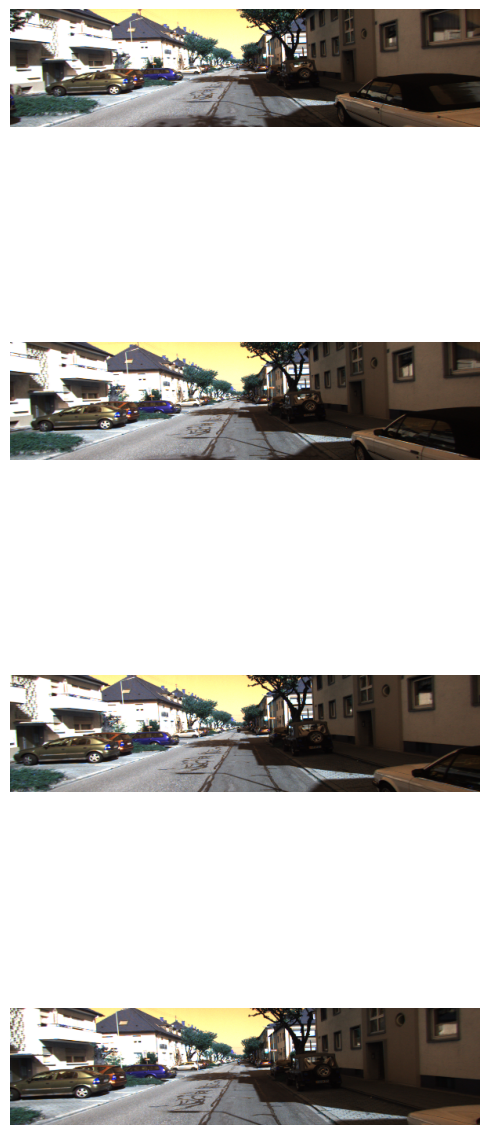

In [5]:
display_image_sequence(train_images[15], cmap='viridis')

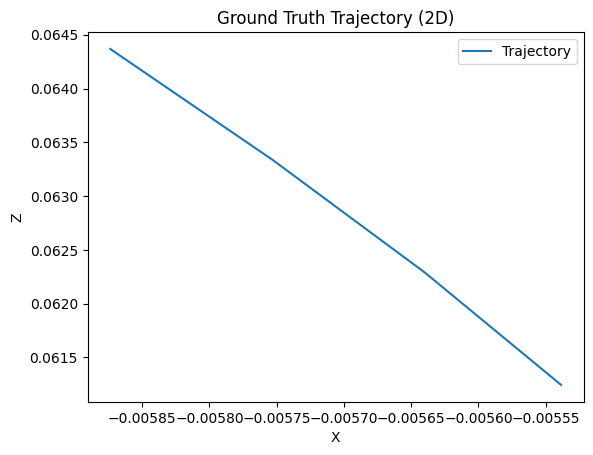

In [6]:
plot_trajectory(train_poses_6dof_normalized[15])

In [7]:
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_poses_tensor = torch.tensor(train_poses_6dof, dtype=torch.float32)
dataset = TensorDataset(train_images_tensor,train_poses_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [8]:
#loading pretrained flownet model
flownet_model = torch.load("pretrained_model_weights/flownets_bn_EPE2.459.pth")

/tmp/ipykernel_115877/3034515116.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flownet_model = torch.load("pretrained_model_weights/flownets_bn_EPE2.459.pth")


In [9]:
#DeepVO model based on the paper
class DeepVO(nn.Module):
    def __init__(self):
        super(DeepVO, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Dropout(0.1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.1)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.1)
        )

        self.conv3_1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.1)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.1)
        )

        self.conv4_1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.1)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.1)
        )

        self.conv5_1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.1)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.1)
        )

        self.rnn = nn.LSTM(input_size=30720, hidden_size=1000, num_layers=2, dropout=0.2, batch_first=True)
        self.rnn_dropout = nn.Dropout(0.5)
        self.linear = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 6)
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.LSTM):
                # layer 1
                kaiming_normal_(m.weight_ih_l0)  #orthogonal_(m.weight_ih_l0)
                kaiming_normal_(m.weight_hh_l0)
                m.bias_ih_l0.data.zero_()
                m.bias_hh_l0.data.zero_()
                # Set forget gate bias to 1 (remember)
                n = m.bias_hh_l0.size(0)
                start, end = n//4, n//2
                m.bias_hh_l0.data[start:end].fill_(1.)

                # layer 2
                kaiming_normal_(m.weight_ih_l1)  #orthogonal_(m.weight_ih_l1)
                kaiming_normal_(m.weight_hh_l1)
                m.bias_ih_l1.data.zero_()
                m.bias_hh_l1.data.zero_()
                n = m.bias_hh_l1.size(0)
                start, end = n//4, n//2
                m.bias_hh_l1.data[start:end].fill_(1.)

            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        # self.linear2 = nn.Linear(50,6)

    def forward(self, x):
       
        x = torch.cat((x[:, :-1], x[:, 1:]), dim=4)
        x = x.permute(0, 1, 4, 2, 3)
       
        batch_size = x.size(0)
        seq_len = x.size(1)

        x = x.view(batch_size*seq_len, x.size(2), x.size(3),x.size(4))
        x = self.encode_image(x)
        x = x.reshape(batch_size, seq_len, -1)

       
        out, _ = self.rnn(x)
        out = self.rnn_dropout(out)
        out = (self.linear(out))
        return out

    def encode_image(self, x):
        out_conv2 = self.conv2(self.conv1(x))
        out_conv3 = self.conv3_1(self.conv3(out_conv2))
        out_conv4 = self.conv4_1(self.conv4(out_conv3))
        out_conv5 = self.conv5_1(self.conv5(out_conv4))
        out_conv6 = self.conv6(out_conv5)
        return out_conv6


def get_loss(outputs, labels):
   
    y = labels[:, 1:, :]
 
    translation_loss = F.mse_loss(outputs[:, :, :3], y[:, :, :3])
    angle_loss = F.mse_loss(outputs[:, :, 3:], y[:, :, 3:])
    
   
    total_loss = (100 * angle_loss + translation_loss) 
    return angle_loss, translation_loss, total_loss


def train(model, train_loader, criterion, optimizer, device):
    model.train() 
    running_loss = 0.0
    angle_loss = 0.0
    translational_loss = 0.0
   
   

    for inputs, labels in train_loader:
       
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()              
        outputs = model(inputs)
                  
        a_loss, t_loss, loss = criterion(outputs, labels)  

        loss.backward()                    
        optimizer.step()                   
        angle_loss += a_loss
        translational_loss += t_loss
        running_loss += loss

    epoch_loss = running_loss / len(train_loader)
    epoch_a_loss = angle_loss / len(train_loader)
    epoch_t_loss = translational_loss / len(train_loader)
     

    print(f"Train Loss: {epoch_loss:.6f}")
    print(f"Angle loss: {epoch_a_loss}")
    print(f"translational loss: {epoch_t_loss}")
    return epoch_loss


In [10]:
model = DeepVO().to(device)

#updating flownet weights to cnn layers
model_dict = model.state_dict()
update_dict = {k: v for k, v in flownet_model['state_dict'].items() if k in model_dict}
model_dict.update(update_dict)
model.load_state_dict(model_dict)


<All keys matched successfully>

In [11]:
print("updated params form flownet:")
for k in update_dict:
    print(k)

updated params form flownet:
conv1.0.weight
conv1.1.weight
conv1.1.bias
conv1.1.running_mean
conv1.1.running_var
conv2.0.weight
conv2.1.weight
conv2.1.bias
conv2.1.running_mean
conv2.1.running_var
conv3.0.weight
conv3.1.weight
conv3.1.bias
conv3.1.running_mean
conv3.1.running_var
conv3_1.0.weight
conv3_1.1.weight
conv3_1.1.bias
conv3_1.1.running_mean
conv3_1.1.running_var
conv4.0.weight
conv4.1.weight
conv4.1.bias
conv4.1.running_mean
conv4.1.running_var
conv4_1.0.weight
conv4_1.1.weight
conv4_1.1.bias
conv4_1.1.running_mean
conv4_1.1.running_var
conv5.0.weight
conv5.1.weight
conv5.1.bias
conv5.1.running_mean
conv5.1.running_var
conv5_1.0.weight
conv5_1.1.weight
conv5_1.1.bias
conv5_1.1.running_mean
conv5_1.1.running_var
conv6.0.weight
conv6.1.weight
conv6.1.bias
conv6.1.running_mean
conv6.1.running_var


In [12]:
#hyperparams
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)
criterion = get_loss
num_epochs = 200

In [13]:
#training loop
train_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_loss = train(model, dataloader, criterion, optimizer, device)
    train_losses.append(train_loss)

Epoch 1/200
Train Loss: 46186.621094
Angle loss: 79.01078796386719
translational loss: 38285.55078125
Epoch 2/200
Train Loss: 32871.671875
Angle loss: 85.44341278076172
translational loss: 24327.3125
Epoch 3/200
Train Loss: 27636.947266
Angle loss: 76.57710266113281
translational loss: 19979.240234375
Epoch 4/200
Train Loss: 24620.507812
Angle loss: 66.80628204345703
translational loss: 17939.890625
Epoch 5/200
Train Loss: 22182.519531
Angle loss: 56.83690643310547
translational loss: 16498.849609375
Epoch 6/200
Train Loss: 20163.365234
Angle loss: 51.85184860229492
translational loss: 14978.1923828125
Epoch 7/200
Train Loss: 18367.312500
Angle loss: 48.07554626464844
translational loss: 13559.7548828125
Epoch 8/200
Train Loss: 17029.386719
Angle loss: 43.0397834777832
translational loss: 12725.4052734375
Epoch 9/200
Train Loss: 15822.239258
Angle loss: 40.030555725097656
translational loss: 11819.1845703125
Epoch 10/200
Train Loss: 14863.926758
Angle loss: 36.12797546386719
translatio

In [14]:
torch.save(model, "trained_models/model-with-processed-image.pth")

In [15]:
data_path = "processed_dataset"
test_images, test_poses = load_kitti_sequences(data_path, ['08'])
test_images= np.stack([np.stack(seq, axis=0) for seq in test_images], axis=0)
test_poses= np.stack([np.stack(seq, axis=0) for seq in test_poses], axis=0)
test_poses_6dof = convert_12dof_to_6dof(test_poses)
test_poses_dof_normalized, test_max_translation = normalize_pose_vector(test_poses_6dof)

test_images_tensor = torch.tensor(test_images, dtype=torch.float32) 
test_poses_tensor = torch.tensor(test_poses_6dof, dtype=torch.float32)
test_dataset = TensorDataset(test_images_tensor,test_poses_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

08
Generated subsequences of length 4 for sequence 08


In [32]:
model.eval()
all_outputs = []
outputs_vec = []
all_labels = []
with torch.no_grad():
    for images,labels in test_dataloader:
        images = images.to(device)
        outputs = model(images)
       
        outputs = outputs.cpu()  
        # Combine batch and sequence dimensions into a single continuous sequence
        batch_size, seq_len, _ = outputs.shape
        outputs_vec.append(outputs)
        outputs = outputs.view(batch_size * seq_len, 6)
        labels = labels.view(batch_size * (seq_len+1), 6)
        all_outputs.append(outputs)
        all_labels.append(labels)

In [33]:
output_vec = np.concatenate(outputs_vec)
all_outputs_denormed = denormalize_pose_vector(output_vec, max_translation)
final_sequence = torch.cat(all_outputs, dim=0)  # Stack along the sequence dimension
input_sequence = torch.cat(all_labels, dim=0)
print(final_sequence.shape)  # Should output [seq, 6]

torch.Size([1191, 6])


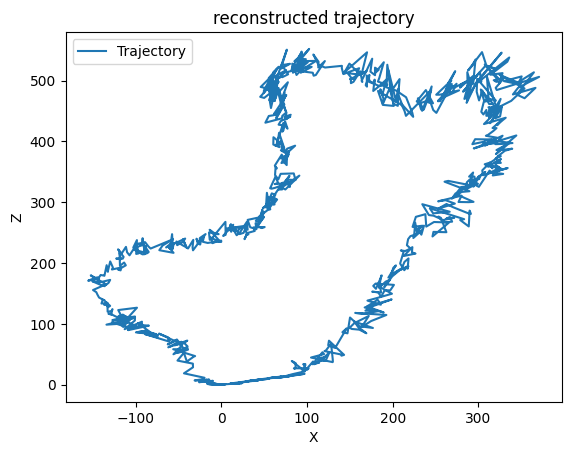

In [34]:
plot_trajectory(final_sequence, "reconstructed trajectory")

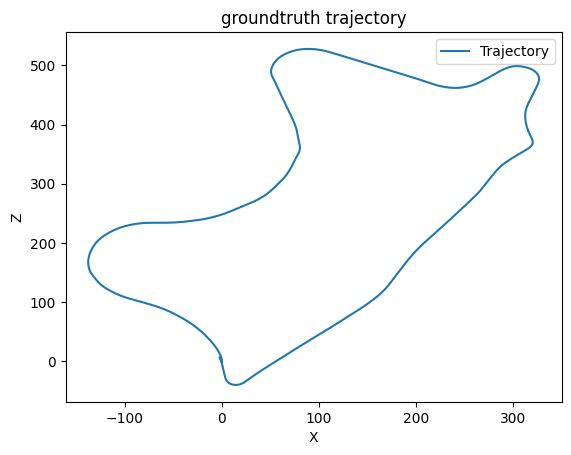

In [35]:
plot_trajectory(input_sequence, "groundtruth trajectory")

In [36]:
data_path = "processed_dataset"
test_images, test_poses = load_kitti_sequences(data_path, ['00'])
test_images= np.stack([np.stack(seq, axis=0) for seq in test_images], axis=0)
test_poses= np.stack([np.stack(seq, axis=0) for seq in test_poses], axis=0)
test_poses_6dof = convert_12dof_to_6dof(test_poses)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32) 
test_poses_tensor = torch.tensor(test_poses_6dof, dtype=torch.float32)
test_dataset = TensorDataset(test_images_tensor,test_poses_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
model.eval()

00
Generated subsequences of length 4 for sequence 00


DeepVO(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.1, inplace=False)
  )
  (conv3_1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNor

In [37]:
all_outputs = []
all_labels = []
with torch.no_grad():
    for images,labels in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        # print(outputs.shape)
        # print(labels.shape)
        outputs = outputs.cpu()  # Move outputs back to CPU
          # Combine batch and sequence dimensions into a single continuous sequence
        batch_size, seq_len, _ = outputs.shape
        outputs = outputs.view(batch_size * seq_len, 6)  # Flatten batch and sequence
        labels = labels.view(batch_size * (seq_len+1), 6)
        all_outputs.append(outputs)
        all_labels.append(labels)

final_sequence = torch.cat(all_outputs, dim=0)  # Stack along the sequence dimension
input_sequence = torch.cat(all_labels, dim=0)
print(final_sequence.shape)  # Should output [seq, 6]

torch.Size([3405, 6])


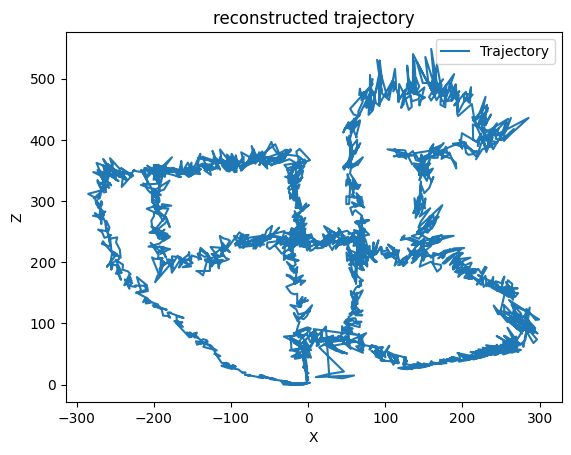

In [38]:
plot_trajectory(final_sequence, "reconstructed trajectory")

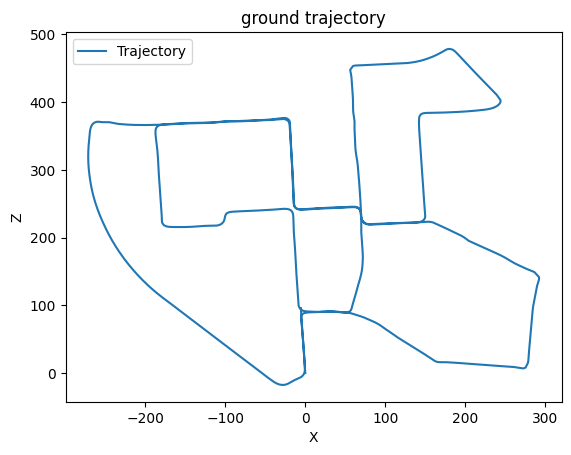

In [39]:
plot_trajectory(input_sequence, "ground trajectory")

08
Generated subsequences of length 4 for sequence 08


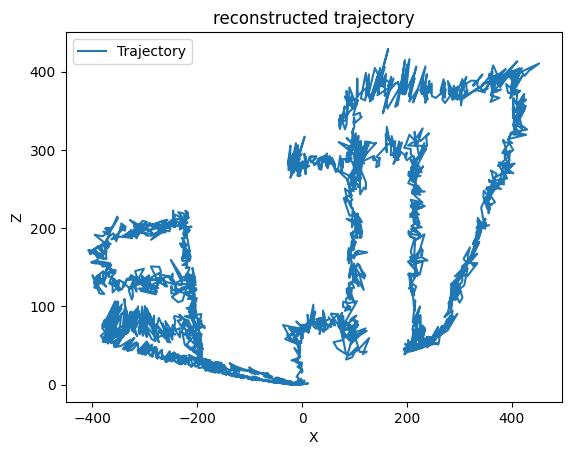

In [40]:
data_path = "processed_dataset"
test_images, test_poses = load_kitti_sequences(data_path, ['08'])
test_images= np.stack([np.stack(seq, axis=0) for seq in test_images], axis=0)
test_poses= np.stack([np.stack(seq, axis=0) for seq in test_poses], axis=0)
test_poses_6dof = convert_12dof_to_6dof(test_poses)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32) 
test_poses_tensor = torch.tensor(test_poses_6dof, dtype=torch.float32)
test_dataset = TensorDataset(test_images_tensor,test_poses_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
model.eval()
all_outputs = []
all_labels = []
with torch.no_grad():
    for images,labels in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        # print(outputs.shape)
        # print(labels.shape)
        outputs = outputs.cpu()  # Move outputs back to CPU
          # Combine batch and sequence dimensions into a single continuous sequence
        batch_size, seq_len, _ = outputs.shape
        outputs = outputs.view(batch_size * seq_len, 6)  # Flatten batch and sequence
        labels = labels.view(batch_size * (seq_len+1), 6)
        all_outputs.append(outputs)
        all_labels.append(labels)

final_sequence = torch.cat(all_outputs, dim=0)  # Stack along the sequence dimension
input_sequence = torch.cat(all_labels, dim=0)

plot_trajectory(final_sequence,"reconstructed trajectory")

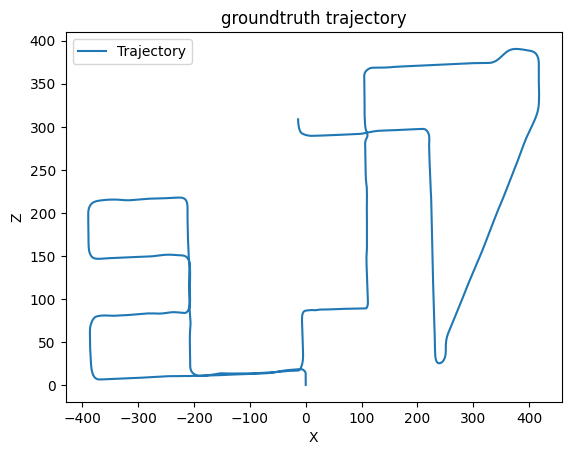

In [41]:
plot_trajectory(input_sequence,"groundtruth trajectory")

09
Generated subsequences of length 4 for sequence 09


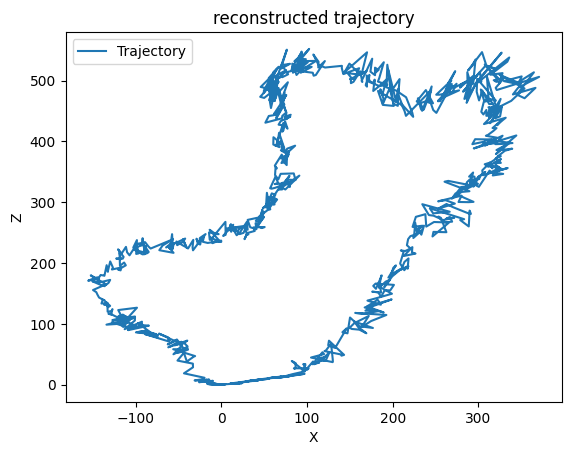

In [42]:
data_path = "processed_dataset"
test_images, test_poses = load_kitti_sequences(data_path, ['09'])
test_images= np.stack([np.stack(seq, axis=0) for seq in test_images], axis=0)
test_poses= np.stack([np.stack(seq, axis=0) for seq in test_poses], axis=0)
test_poses_6dof = convert_12dof_to_6dof(test_poses)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32) 
test_poses_tensor = torch.tensor(test_poses_6dof, dtype=torch.float32)
test_dataset = TensorDataset(test_images_tensor,test_poses_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
model.eval()
all_outputs = []
all_labels = []
with torch.no_grad():
    for images,labels in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        # print(outputs.shape)
        # print(labels.shape)
        outputs = outputs.cpu()  # Move outputs back to CPU
          # Combine batch and sequence dimensions into a single continuous sequence
        batch_size, seq_len, _ = outputs.shape
        outputs = outputs.view(batch_size * seq_len, 6)  # Flatten batch and sequence
        labels = labels.view(batch_size * (seq_len+1), 6)
        all_outputs.append(outputs)
        all_labels.append(labels)

final_sequence = torch.cat(all_outputs, dim=0)  # Stack along the sequence dimension
input_sequence = torch.cat(all_labels, dim=0)

plot_trajectory(final_sequence, "reconstructed trajectory")

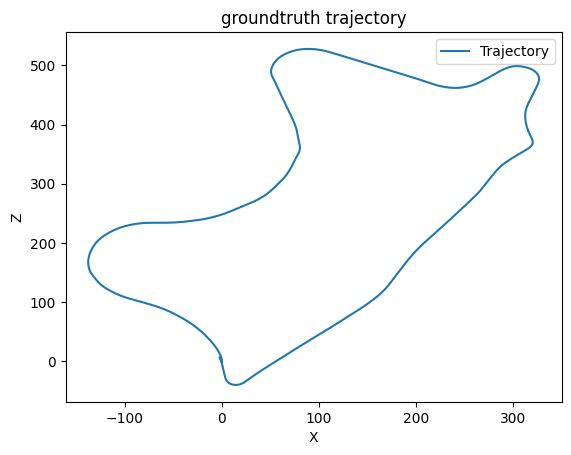

In [43]:
plot_trajectory(input_sequence, "groundtruth trajectory")